# 📈 Week 13 Trading Strategy: Neural Networks

---

## 🎯 Strategy Overview

**Building on Weeks 1-12 + Adding Week 13 Concepts:**
- All previous ML methods (regression, classification, trees)
- **NEW:** Multi-Layer Perceptron (MLP) for return prediction
- **NEW:** PyTorch implementation
- **NEW:** Deep learning regularization techniques
- **NEW:** Neural network ensemble

**Strategy Logic:**
1. Engineer features from price/volume data
2. Train MLP models with proper regularization
3. Compare with traditional ML models
4. Generate probability-weighted trading signals

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
PREDICTION_HORIZON = 5

print("=" * 60)
print("📊 WEEK 13 TRADING STRATEGY: NEURAL NETWORKS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Prediction horizon: {PREDICTION_HORIZON} days")

📊 WEEK 13 TRADING STRATEGY: NEURAL NETWORKS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Prediction horizon: 5 days


In [2]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")
print(f"   PyTorch version: {torch.__version__}")


📥 Downloading market data...
✅ Loaded 504 trading days
   PyTorch version: 2.9.1


---

## 📊 Section 1: Feature Engineering

**Creating comprehensive features for neural networks:**
- Momentum (lagged returns)
- Volatility features
- Technical indicators
- Cross-asset features

In [3]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def create_nn_features(prices, returns, volumes, ticker):
    """Create features for neural network."""
    df = pd.DataFrame(index=returns.index)
    
    close = prices[ticker]
    ret = returns[ticker]
    
    # Lagged returns
    for lag in [1, 2, 3, 5, 10, 20]:
        df[f'ret_lag_{lag}'] = ret.shift(lag)
    
    # Volatility
    df['vol_5'] = ret.rolling(5).std().shift(1)
    df['vol_20'] = ret.rolling(20).std().shift(1)
    df['vol_ratio'] = df['vol_5'] / df['vol_20']
    
    # Moving averages
    df['ma_5_20'] = (close.rolling(5).mean() / close.rolling(20).mean() - 1).shift(1)
    df['ma_10_50'] = (close.rolling(10).mean() / close.rolling(50).mean() - 1).shift(1)
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - (100 / (1 + gain / loss))).shift(1) / 100  # Normalize
    
    # MACD
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    df['macd'] = ((ema12 - ema26) / close).shift(1)
    
    # Volume
    if ticker in volumes.columns:
        df['volume_ratio'] = (volumes[ticker] / volumes[ticker].rolling(20).mean()).shift(1)
    
    return df

def create_labels(returns, ticker, horizon=PREDICTION_HORIZON):
    """Create classification labels."""
    future_ret = returns[ticker].shift(-horizon).rolling(horizon).mean() * horizon
    labels = pd.Series(index=returns.index, dtype=int)
    labels[future_ret > 0.01] = 1   # Up
    labels[future_ret < -0.01] = -1  # Down
    labels[(future_ret >= -0.01) & (future_ret <= 0.01)] = 0  # Neutral
    return labels

# Create features and labels
features_dict = {}
labels_dict = {}

for ticker in TICKERS:
    features_dict[ticker] = create_nn_features(prices, returns, volumes, ticker)
    labels_dict[ticker] = create_labels(returns, ticker)

print(f"✅ Created {len(features_dict[TICKERS[0]].columns)} features per ticker")

✅ Created 14 features per ticker


---

## 📊 Section 2: MLP Model Definition

**Neural Network Architecture:**
- Input Layer: Features
- Hidden Layers: 64 → 32 → 16 neurons
- Output Layer: 3 classes (Down, Neutral, Up)
- Activation: ReLU + Dropout

In [4]:
# ============================================================
# MLP MODEL DEFINITION
# ============================================================

class TradingMLP(nn.Module):
    """Multi-Layer Perceptron for Trading Signals."""
    
    def __init__(self, input_size, hidden_sizes=[64, 32, 16], num_classes=3, dropout=0.3):
        super(TradingMLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp(X_train, y_train, X_val, y_val, epochs=100, lr=0.001):
    """Train MLP model."""
    
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.LongTensor(y_train + 1)  # Shift labels to 0, 1, 2
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.LongTensor(y_val + 1)
    
    # Model
    model = TradingMLP(X_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val_t)
            val_loss = criterion(val_output, y_val_t)
            val_losses.append(val_loss.item())
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 20:
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

print("✅ MLP model class defined")

✅ MLP model class defined


In [5]:
# ============================================================
# MODEL TRAINING
# ============================================================

def train_models_for_ticker(features, labels, ticker):
    """Train MLP and baseline models."""
    
    # Align data
    common_idx = features.index.intersection(labels.index)
    X = features.loc[common_idx].dropna()
    y = labels.loc[X.index].dropna()
    common = X.index.intersection(y.index)
    X = X.loc[common]
    y = y.loc[common]
    
    if len(X) < 200:
        return None
    
    # Train/val/test split
    train_end = int(len(X) * 0.6)
    val_end = int(len(X) * 0.8)
    
    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
    y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train MLP
    torch.manual_seed(42)
    mlp_model, train_losses, val_losses = train_mlp(
        X_train_scaled, y_train.values,
        X_val_scaled, y_val.values,
        epochs=150
    )
    
    # MLP predictions
    mlp_model.eval()
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test_scaled)
        mlp_output = mlp_model(X_test_t)
        mlp_probs = torch.softmax(mlp_output, dim=1).numpy()
        mlp_pred = mlp_output.argmax(dim=1).numpy() - 1  # Back to -1, 0, 1
    
    # Train Random Forest (baseline)
    rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    
    # Evaluate
    mlp_acc = accuracy_score(y_test, mlp_pred)
    mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    
    return {
        'mlp_model': mlp_model,
        'rf_model': rf,
        'scaler': scaler,
        'mlp_acc': mlp_acc,
        'mlp_f1': mlp_f1,
        'rf_acc': rf_acc,
        'rf_f1': rf_f1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'mlp_probs': mlp_probs,
        'X_test': X_test,
        'y_test': y_test
    }

# Train for all tickers
print("📊 MODEL TRAINING")
print("=" * 80)
print(f"\n{'Ticker':<10} {'MLP Acc':>12} {'MLP F1':>10} {'RF Acc':>12} {'RF F1':>10}")
print("-" * 80)

all_results = {}
for ticker in TICKERS:
    result = train_models_for_ticker(features_dict[ticker], labels_dict[ticker], ticker)
    if result:
        all_results[ticker] = result
        print(f"{ticker:<10} {result['mlp_acc']:>11.2%} {result['mlp_f1']:>9.3f} {result['rf_acc']:>11.2%} {result['rf_f1']:>9.3f}")

📊 MODEL TRAINING

Ticker          MLP Acc     MLP F1       RF Acc      RF F1
--------------------------------------------------------------------------------
AAPL            24.44%     0.185      14.44%     0.119
MSFT            34.44%     0.246      35.56%     0.292
GOOGL           37.78%     0.325      36.67%     0.315
AMZN            45.56%     0.402      46.67%     0.426
META            35.56%     0.245      33.33%     0.172


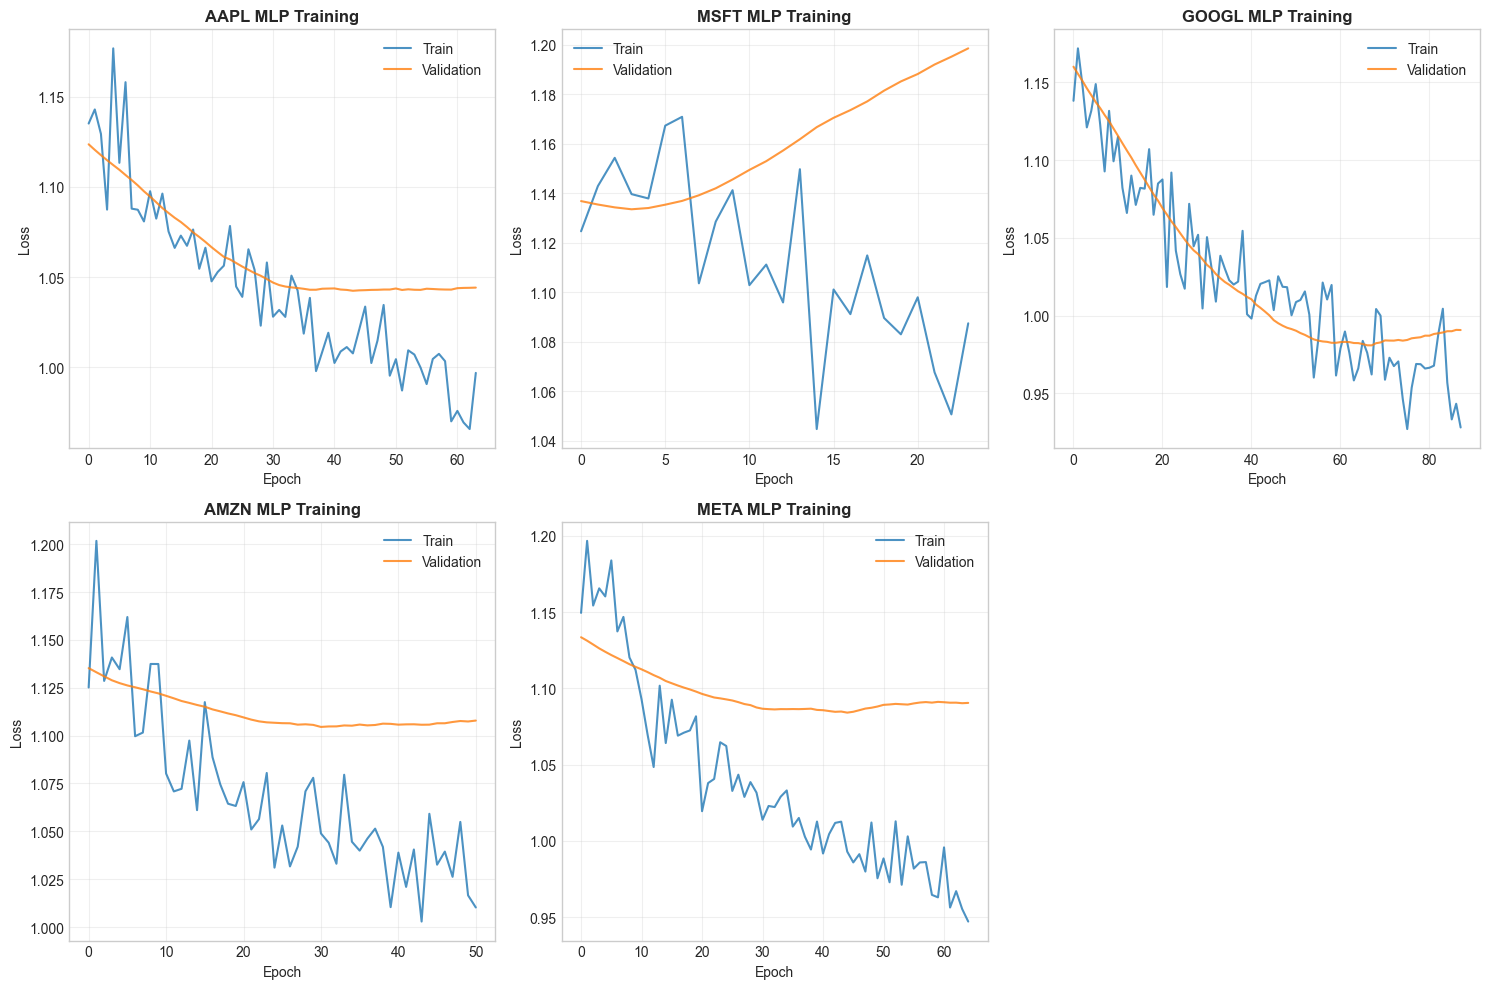

In [6]:
# ============================================================
# TRAINING VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    if ticker in all_results:
        ax.plot(all_results[ticker]['train_losses'], label='Train', alpha=0.8)
        ax.plot(all_results[ticker]['val_losses'], label='Validation', alpha=0.8)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'{ticker} MLP Training', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 📊 Section 3: Model Comparison

**Comparing MLP vs Traditional ML:**
- Accuracy on test set
- F1 Score (weighted)
- Prediction confidence

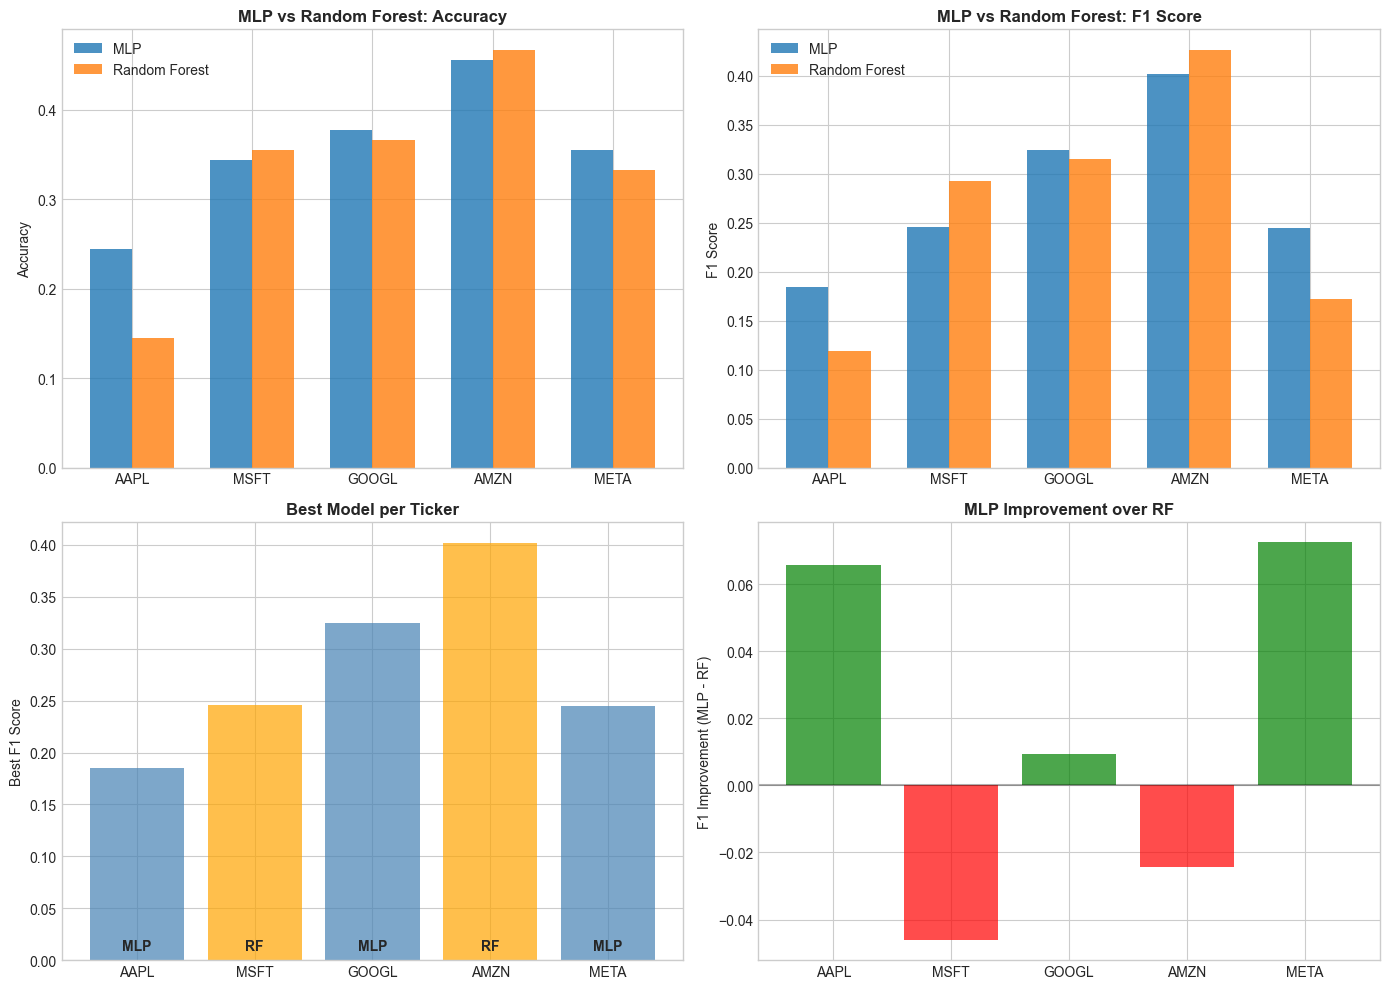

In [7]:
# ============================================================
# MODEL COMPARISON VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
x = np.arange(len(TICKERS))
width = 0.35
mlp_accs = [all_results[t]['mlp_acc'] if t in all_results else 0 for t in TICKERS]
rf_accs = [all_results[t]['rf_acc'] if t in all_results else 0 for t in TICKERS]
ax1.bar(x - width/2, mlp_accs, width, label='MLP', alpha=0.8)
ax1.bar(x + width/2, rf_accs, width, label='Random Forest', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('Accuracy')
ax1.set_title('MLP vs Random Forest: Accuracy', fontweight='bold')
ax1.legend()

# 2. F1 Score Comparison
ax2 = axes[0, 1]
mlp_f1s = [all_results[t]['mlp_f1'] if t in all_results else 0 for t in TICKERS]
rf_f1s = [all_results[t]['rf_f1'] if t in all_results else 0 for t in TICKERS]
ax2.bar(x - width/2, mlp_f1s, width, label='MLP', alpha=0.8)
ax2.bar(x + width/2, rf_f1s, width, label='Random Forest', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.set_ylabel('F1 Score')
ax2.set_title('MLP vs Random Forest: F1 Score', fontweight='bold')
ax2.legend()

# 3. Winner per Ticker
ax3 = axes[1, 0]
winners = []
for ticker in TICKERS:
    if ticker in all_results:
        if all_results[ticker]['mlp_f1'] > all_results[ticker]['rf_f1']:
            winners.append('MLP')
        else:
            winners.append('RF')
    else:
        winners.append('N/A')

colors = ['steelblue' if w == 'MLP' else 'orange' for w in winners]
bars = ax3.bar(TICKERS, [all_results[t]['mlp_f1'] if t in all_results else 0 for t in TICKERS], color=colors, alpha=0.7)
ax3.set_ylabel('Best F1 Score')
ax3.set_title('Best Model per Ticker', fontweight='bold')
for i, (t, w) in enumerate(zip(TICKERS, winners)):
    ax3.text(i, 0.01, w, ha='center', fontsize=10, fontweight='bold')

# 4. Improvement from MLP
ax4 = axes[1, 1]
improvements = []
for ticker in TICKERS:
    if ticker in all_results:
        imp = all_results[ticker]['mlp_f1'] - all_results[ticker]['rf_f1']
        improvements.append(imp)
    else:
        improvements.append(0)

colors = ['green' if i > 0 else 'red' for i in improvements]
ax4.bar(TICKERS, improvements, color=colors, alpha=0.7)
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax4.set_ylabel('F1 Improvement (MLP - RF)')
ax4.set_title('MLP Improvement over RF', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# TRADING SIGNALS
# ============================================================

def get_nn_signal(ticker, all_results, features_dict):
    """Get trading signal from neural network."""
    if ticker not in all_results:
        return {'signal': 'N/A', 'confidence': 0, 'model': 'N/A'}
    
    result = all_results[ticker]
    
    # Get latest features
    features = features_dict[ticker].dropna().iloc[[-1]]
    if len(features) == 0:
        return {'signal': 'N/A', 'confidence': 0, 'model': 'MLP'}
    
    # Scale and predict
    X_scaled = result['scaler'].transform(features)
    X_t = torch.FloatTensor(X_scaled)
    
    result['mlp_model'].eval()
    with torch.no_grad():
        output = result['mlp_model'](X_t)
        probs = torch.softmax(output, dim=1).numpy()[0]
        pred = output.argmax(dim=1).item() - 1  # Back to -1, 0, 1
    
    confidence = max(probs)
    signal = 'BUY' if pred == 1 else ('SELL' if pred == -1 else 'HOLD')
    
    return {
        'signal': signal,
        'confidence': confidence,
        'prediction': pred,
        'probs': probs,
        'model': 'MLP'
    }

print("📊 NEURAL NETWORK TRADING SIGNALS")
print("=" * 75)
print(f"\n{'Ticker':<10} {'Signal':>10} {'Confidence':>12} {'P(Down)':>10} {'P(Neutral)':>12} {'P(Up)':>10}")
print("-" * 75)

current_signals = {}
for ticker in TICKERS:
    signal_info = get_nn_signal(ticker, all_results, features_dict)
    current_signals[ticker] = signal_info
    
    if 'probs' in signal_info:
        probs = signal_info['probs']
        emoji = "📈" if signal_info['signal'] == 'BUY' else ("📉" if signal_info['signal'] == 'SELL' else "⚪")
        print(f"{ticker:<10} {emoji} {signal_info['signal']:>6} {signal_info['confidence']:>11.1%} {probs[0]:>9.1%} {probs[1]:>11.1%} {probs[2]:>9.1%}")

📊 NEURAL NETWORK TRADING SIGNALS

Ticker         Signal   Confidence    P(Down)   P(Neutral)      P(Up)
---------------------------------------------------------------------------
AAPL       📈    BUY       61.3%     17.1%       21.6%     61.3%
MSFT       📉   SELL       35.3%     35.3%       33.5%     31.1%
GOOGL      📈    BUY       42.6%     34.5%       22.9%     42.6%
AMZN       📈    BUY       39.0%     38.7%       22.2%     39.0%
META       📈    BUY       53.6%     30.4%       16.0%     53.6%


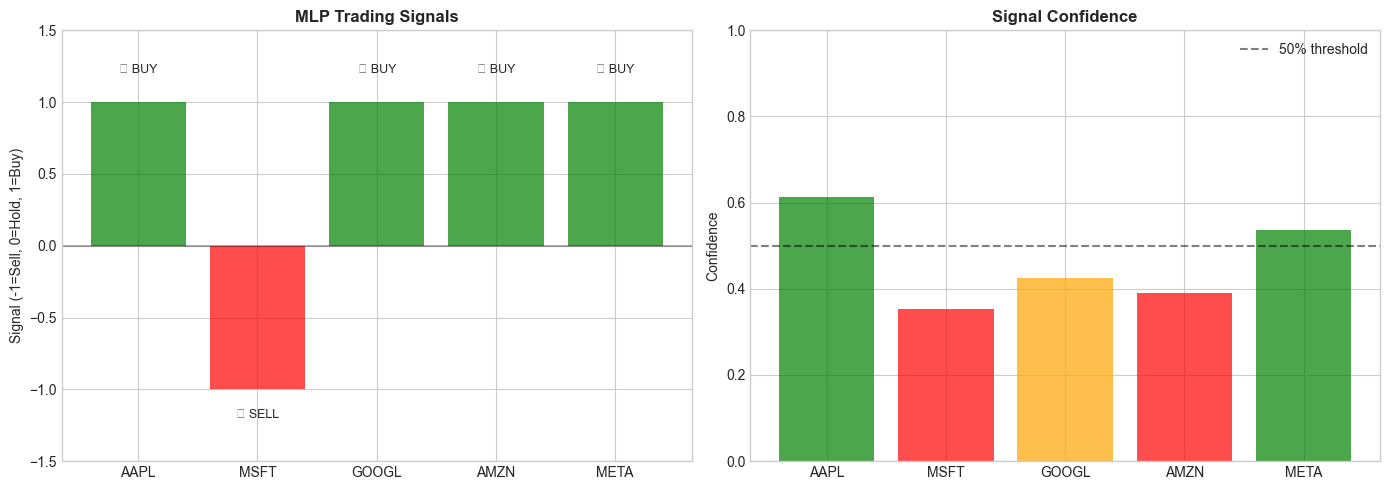

In [9]:
# ============================================================
# SIGNAL VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Current Signals
ax1 = axes[0]
signals = [current_signals[t].get('prediction', 0) for t in TICKERS]
colors = ['green' if s == 1 else ('red' if s == -1 else 'gray') for s in signals]
ax1.bar(TICKERS, signals, color=colors, alpha=0.7)
ax1.set_ylabel('Signal (-1=Sell, 0=Hold, 1=Buy)')
ax1.set_title('MLP Trading Signals', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.set_ylim(-1.5, 1.5)

for i, (t, s) in enumerate(zip(TICKERS, signals)):
    label = "📈 BUY" if s == 1 else ("📉 SELL" if s == -1 else "⚪ HOLD")
    ax1.text(i, s + 0.2 * np.sign(s + 0.001), label, ha='center', fontsize=9)

# 2. Confidence Levels
ax2 = axes[1]
confidences = [current_signals[t].get('confidence', 0) for t in TICKERS]
colors = ['green' if c > 0.5 else ('orange' if c > 0.4 else 'red') for c in confidences]
ax2.bar(TICKERS, confidences, color=colors, alpha=0.7)
ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='50% threshold')
ax2.set_ylabel('Confidence')
ax2.set_title('Signal Confidence', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 13 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
summary = pd.DataFrame({
    'MLP Acc': [all_results[t]['mlp_acc'] if t in all_results else 0 for t in TICKERS],
    'MLP F1': [all_results[t]['mlp_f1'] if t in all_results else 0 for t in TICKERS],
    'RF F1': [all_results[t]['rf_f1'] if t in all_results else 0 for t in TICKERS],
    'Signal': [current_signals[t]['signal'] for t in TICKERS],
    'Confidence': [current_signals[t].get('confidence', 0) for t in TICKERS]
}, index=TICKERS)

print("\n📋 MODEL & SIGNAL SUMMARY:")
print(summary.round(3).to_string())

# Recommendations
buys = [t for t in TICKERS if current_signals[t]['signal'] == 'BUY']
sells = [t for t in TICKERS if current_signals[t]['signal'] == 'SELL']
holds = [t for t in TICKERS if current_signals[t]['signal'] == 'HOLD']

print("\n🏆 NEURAL NETWORK RECOMMENDATIONS:")
print(f"\n📈 BUY: {buys if buys else 'None'}")
print(f"📉 SELL: {sells if sells else 'None'}")
print(f"⚪ HOLD: {holds if holds else 'None'}")

# High confidence
high_conf = [(t, current_signals[t]) for t in TICKERS 
             if current_signals[t].get('confidence', 0) > 0.5 and current_signals[t]['signal'] != 'HOLD']

if high_conf:
    print("\n⭐ HIGH CONFIDENCE TRADES:")
    for ticker, info in high_conf:
        print(f"   {ticker}: {info['signal']} (Confidence: {info['confidence']:.1%})")

# MLP vs RF winner
mlp_wins = sum(1 for t in TICKERS if t in all_results and all_results[t]['mlp_f1'] > all_results[t]['rf_f1'])
print(f"\n📊 MLP outperformed RF in {mlp_wins}/{len(TICKERS)} tickers")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 13 STRATEGY - FINAL RECOMMENDATIONS

📋 MODEL & SIGNAL SUMMARY:
       MLP Acc  MLP F1  RF F1 Signal  Confidence
AAPL     0.244   0.185  0.119    BUY       0.613
MSFT     0.344   0.246  0.292   SELL       0.353
GOOGL    0.378   0.325  0.315    BUY       0.426
AMZN     0.456   0.402  0.426    BUY       0.390
META     0.356   0.245  0.172    BUY       0.536

🏆 NEURAL NETWORK RECOMMENDATIONS:

📈 BUY: ['AAPL', 'GOOGL', 'AMZN', 'META']
📉 SELL: ['MSFT']
⚪ HOLD: None

⭐ HIGH CONFIDENCE TRADES:
   AAPL: BUY (Confidence: 61.3%)
   META: BUY (Confidence: 53.6%)

📊 MLP outperformed RF in 3/5 tickers

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-13)

| Week | Concept | Application |
|------|---------|-------------|
| 1-6 | Foundation to Factors | Feature engineering |
| 6.1 | Classification | Label generation |
| 7.1 | Tree Ensembles | Baseline comparison |
| 8-12 | Advanced ML | Model selection |
| **13** | **MLP Architecture** | **Deep learning model** |
| **13** | **PyTorch** | **Neural network training** |
| **13** | **Backpropagation** | **Gradient-based learning** |
| **13** | **Regularization** | **Dropout, BatchNorm** |

---